# Module 2 -Genomics and High-Dimensional Data

In [2]:
# Loading modules

import pandas as pd
import numpy as np
import os, time, pickle
from memory_profiler import profile
import matplotlib as mpl
from matplotlib import pyplot as plt


%load_ext memory_profiler
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import MDS, TSNE

# Scipy for Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

# Ignoring warning messages
import warnings
warnings.filterwarnings('ignore')

# Setting random seed
np.random.seed(42)

In [3]:
# Function to save figures

IMAGES_PATH = '../images'
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Problem 1: Small dataset

For this problem, we will practice using visualization and clustering tools on the small dataset in folder p1.

The data consists of a counts matrix X in file Y and X, along with ground truth labels . The ground truth labels are not necessary for this part, but you may use them to erify that your result are sensible.

Load the data in X.npy. How many cells and genes are in this data set? What is the value of the largest entry in the first column?

In [4]:
# Loading data

X = np.load("p1/X.npy")
y = np.load("p1/y.npy")

print("Number of cells is:", X.shape[0], "and number of genes is:", X.shape[1])
print("Largest entry in the first columns is:", np.max(X[:,0]))

Number of cells is: 511 and number of genes is: 45768
Largest entry in the first columns is: 11.941397591320595


Due to the presence of genes with extremely high magnitudes of expression in only a few cells, it is common to apply a log-transform to the data, that is, to apply the transform log2(x + 1). Apply this transform to each entry in the raw data.

What is the value of the largest entry in the first column of the processed data matrix?

In [6]:
# Log-transforming data

X_log = np.log2(X + 1)
print("The largest entry in the first column of processed data is:", np.max(X_log[:,0]))

The largest entry in the first column of processed data is: 3.6939215228197613


For both the given raw data and the processed version computed in the previous part, compute the principal components.

For both the raw data and processed version, what percentage of the variance is explained by the first principal component?

In [9]:
# Loading PCA library and fitting data into principal components

pca = PCA().fit(X)
pca_log = PCA().fit(X_log)

In [10]:
# Percentage of variance explained by first component

print("The percentage of variance explained with raw data is:", pca.explained_variance_ratio_[0])
print("The percentage of variance explained with processed data is:", pca_log.explained_variance_ratio_[0])

The percentage of variance explained with raw data is: 0.42779670983572665
The percentage of variance explained with processed data is: 0.13887564870826177


How many PC's are needed to explain 85% of the variance for both raw and processed data? To get a better idea of how the explained variance grow as more PCs are included, plot the cumulative explained variance versus number of PCs.

In [11]:
# Getting 85% variance cutoffs from cumulative sum depending on condition

print("The number of PCs needed for raw data is:", np.where(np.cumsum(pca.explained_variance_ratio_) >= .85)[0][0] + 1)
print("The number of PCs needed for processed data is:", np.where(np.cumsum(pca_log.explained_variance_ratio_) >= .85)[0][0] + 1)

The number of PCs needed for raw data is: 36
The number of PCs needed for processed data is: 339


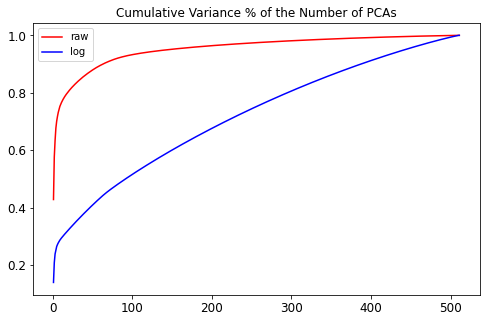

In [12]:
# Plotting the Cumulative variance of PCAs

plt.figure(figsize=(8, 5))
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca.explained_variance_ratio_), color="red", label="raw")
plt.plot(range(1, X.shape[0]+1), np.cumsum(pca_log.explained_variance_ratio_), color="blue", label="log")
plt.legend()
plt.title('Cumulative Variance % of the Number of PCAs')
plt.show()

From now on, we work with the processed data, that is, the data after we apply the log transformation.

We first try to visualize the data with no specialized techniques. Make a scatterplot with the first and second coordinates of the data as the axes.

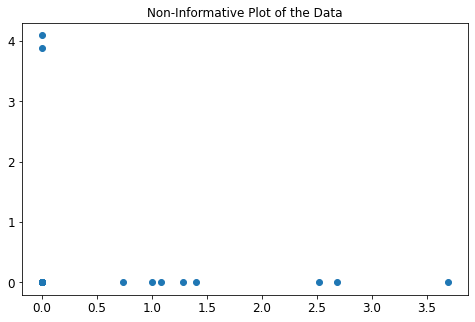

In [13]:
# Plotting the first and second columns of the processed data

plt.figure(figsize=(8, 5))
plt.title("Non-Informative Plot of the Data")
plt.scatter(X_log[:,0],X_log[:,1])
plt.show()

Now find the top two principal components, and make a scatterplot of the projections of the data onto these two PC's. How many visually distinct clusters are there?

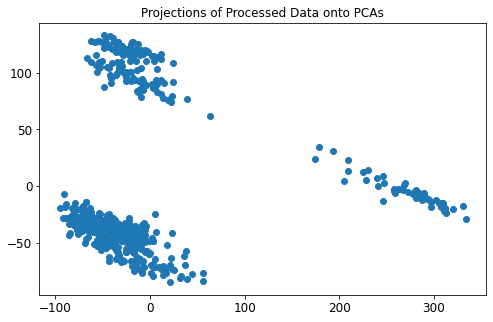

In [14]:
# Transforming processed data into PCAs and plotting the first two components

z = pca_log.transform(X_log)
plt.figure(figsize=(8, 5))
plt.title('Projections of Processed Data onto PCAs')
plt.scatter(z[:,0],z[:,1])
plt.show()

We can see three distinct clusters with some outliers.

Use the sklearn implementation of MDS to visualize the data in two dimensions. How many visually distinct clusters are there?

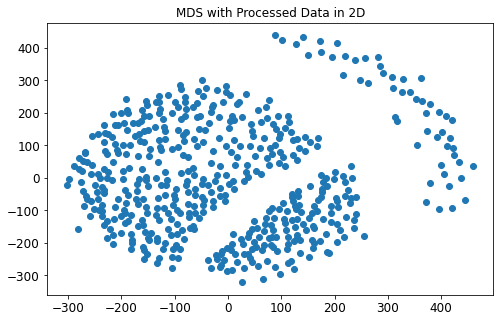

In [15]:
# Loading MDS library, fitting and transforming to two dimensions and plotting results

mds = MDS(n_components=2).fit_transform(X_log)
plt.figure(figsize=(8, 5))
plt.title('MDS with Processed Data in 2D')
plt.scatter(mds[:,0],mds[:,1])
plt.show()

We can see three distinct clusters with some outliers.

Project the data onto the top 50 PC's and run T-SNE with a perplexity value of 40 on the projected data to isualize the data in two dimensions. How many visually distinct cluster are there?

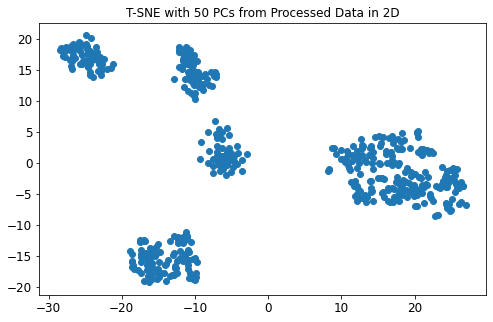

In [14]:
# Loading T-SNE library, fitting and transforming with 50 PCs to two dimensions and plotting results

z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.figure(figsize=(8, 5))
plt.title('T-SNE with 50 PCs from Processed Data in 2D')
plt.scatter(z_tsne[:,0],z_tsne[:,1])
plt.show()

Now we can see five distinct clusters.

In all of the results of the methods there is some randomization involved in the initizalition the methods that produce a bit different, but still coherent, results each time.

We continue to use the log-transformed data projected onto the top 50 PC's.

Run K-Means on the projected data with the number of clusters by selected by looking at the T-SNE plot.

Redo the PCA, MDS, and T-SNE plots from previous part, but now with colors representing the different cluster identities (e.g. use 10 colors if there are 10 clusters).

Consider the clusters that you can distinguish visually in the PCA plot. What is the maximum number of K-means clusters in one visual clusters?

Consider the clusters that you can distinguish visually in the MDS plot. What is the maximum number of K-means clusters in one visual cluster in the MDS plot?

Consider the clusters that you can distinguish visually in the T-SNE plot. What is the maximum number of K-mean clusters in one cluster in the T-SNE plot?

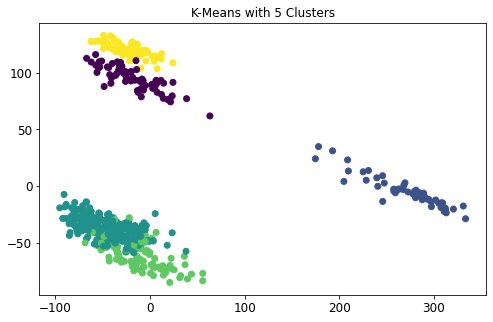

In [15]:
# Running K-Means with 5 clusters, fitting with top 50PCs and plotting results with label colors

k=5
kmeans = KMeans(k, tol=1e-6)
kmeans.fit(z[:,0:50])
plt.figure(figsize=(8, 5))
plt.title('K-Means with 5 Clusters')
plt.scatter(z[:,0],z[:,1], c=kmeans.labels_)
plt.show()

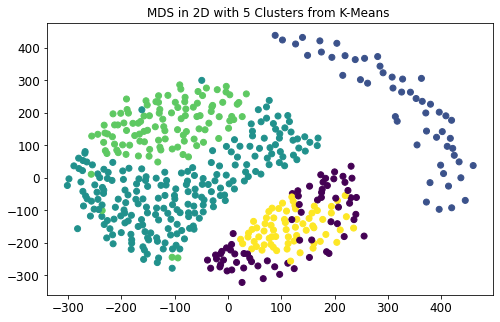

In [16]:
# Using K-Means with 5 clusters to label points for two dimensional MDS

plt.figure(figsize=(8, 5))
plt.title('MDS in 2D with 5 Clusters from K-Means ')
plt.scatter(mds[:,0],mds[:,1],c=kmeans.labels_)
plt.show()

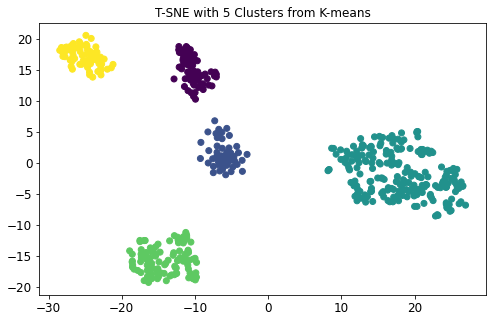

In [17]:
# Using K-means with 4 cluster to label points for T-SNE

plt.figure(figsize=(8, 5))
plt.title('T-SNE with 5 Clusters from K-means')
plt.scatter(z_tsne[:,0],z_tsne[:,1], c=kmeans.labels_)
plt.show()

Use the elbow method to select a number of clusters. In other words, plot the K-Means clustering criterion WGSS versus the number of clusters , and find the number of cluster after the last big drop of the curve.

Clusters is 2 the inertia is: 9520809.578745998
Clusters is 3 the inertia is: 7257882.20119323
Clusters is 4 the inertia is: 6202929.841899473
Clusters is 5 the inertia is: 5962256.915822098
Clusters is 6 the inertia is: 5560958.266163089
Clusters is 7 the inertia is: 5368584.379304656
Clusters is 8 the inertia is: 5326538.964483973
Clusters is 9 the inertia is: 5183475.051753672
Clusters is 10 the inertia is: 5087093.7590904655


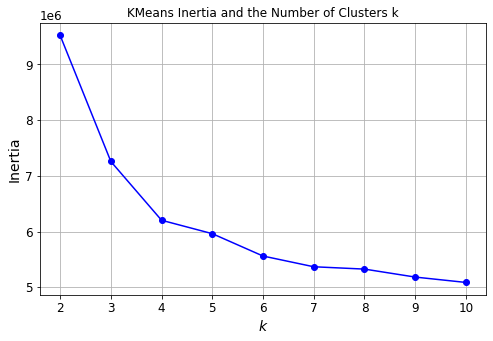

In [18]:
# Plotting K-Means intertia with the number of clusters

all_kmeans = [i for i in range(9)]
for i in range(9):
    cur_kmeans = KMeans(i+2)
    cur_kmeans.fit(z[:,0:50])
    print("Clusters is", i+2, "the inertia is:", cur_kmeans.inertia_)
    all_kmeans[i] = cur_kmeans
plt.figure(figsize=(8, 5))
plt.plot([i+2 for i in range(9)], [all_kmeans[i].inertia_ for i in range(9)], "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title('KMeans Inertia and the Number of Clusters k')
plt.grid(True)
plt.show()

According to the elbow method, we should choose the number k depending on the graph where the last big drop occurs. This would be at k=5 where the inertia is 5,801,585.

If we want to take a closer look at the clusters, we can use the Silhoutte Score which is a metric used to calculate the goodness of a clustering technique. The range of the value is from -1 to +1, where the positive scale indicates that the clusters are well apart from each other and clearly distinguishable, while the more negative we get, the more it is an indication that the clusters are not correctly assigned.

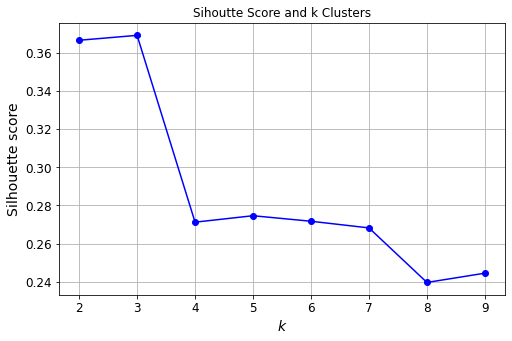

In [19]:
# Silhoutte score of kmeans

silhouette_score(z[:,0:50], kmeans.labels_)
silhouette_scores = [silhouette_score(z[:,0:50], model.labels_) for model in all_kmeans[1:]]
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Sihoutte Score and k Clusters")
plt.grid(True)
plt.show()

From the plot we can see that the score is similar in 2 and 3 clusters and then it drop sharply. We can further investigate this with an even more detailed silhoutte diagram to visualize how balanced the different clusters are when choosing different number of clusters.

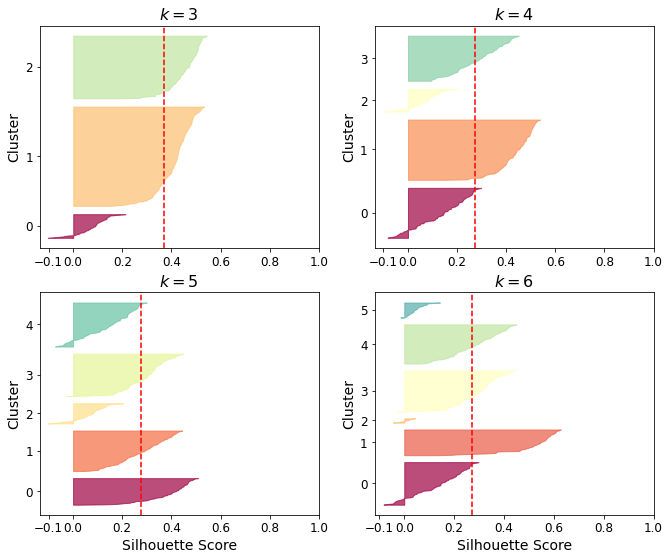

In [20]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2,2,k-2)
    
    y_pred = all_kmeans[k - 1].labels_
    silhouette_coefficients = silhouette_samples(z[:,0:50], y_pred)

    padding = len(z[:,0:50]) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (5, 6):
        plt.ylabel("Cluster")
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Score")

    else:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.ylabel("Cluster")

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

The dashed line indicates the average silhoutte score while the knife shape correspond to the size of the clusters. The widths and lengths should be more or less equal size to indicate that the clusters are well balanced.

Compute the mean value of the data points in each cluster that you found using K-means. For this computation of mean, use the data in full original dimensions instead of the PCA projections (so if the data matrix is n * d and you found k clusters, your cluster means should be k vectors in d dimensions.)

Visualize the k cluster means in 2-dimensional space using MDS and PCA.

In [21]:
# Computing the mean value of the data points in each cluster

cmeans = np.zeros((5, X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]], axis=0)

breaking at iteration 47 with stress 6080.524095596248
breaking at iteration 137 with stress 6080.568168246133
breaking at iteration 77 with stress 6079.000738646771
breaking at iteration 164 with stress 6080.342902116512


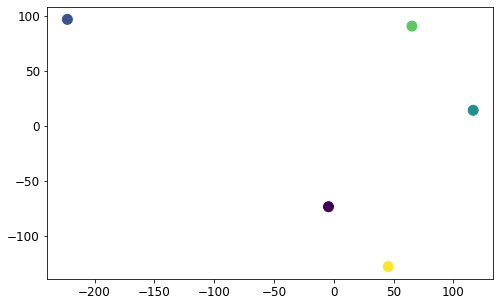

In [22]:
# MDS on K-means cluster means

mds = MDS(n_components=2, verbose=1, eps=1e-5)
mds.fit(cmeans)
plt.figure(figsize=(8, 5))
plt.scatter(mds.embedding_[:,0], mds.embedding_[:,1], c=[0,1,2,3,4], s=100)
plt.show()

We notice from the plots that the MDS and PCA plots confirm that there are three groups of clusters: one group with one cluster mean and two groups with two cluster means each. The two plots also show relatively accurate representation of distances, with one cluster means far away from the others, indicating a different type of cell. On the other hand, from the last plot we can see that the T-SNE does not show any grouping of the cluster means, and instead it places the means at similar distances apart.

Now we consider what would have ahppened if we did not take a log transform of the data.

Perform the PCA, MDS, and T-SNE visualizations from previous parts (with the same parameters) using the orginal data, before you took the log transform.

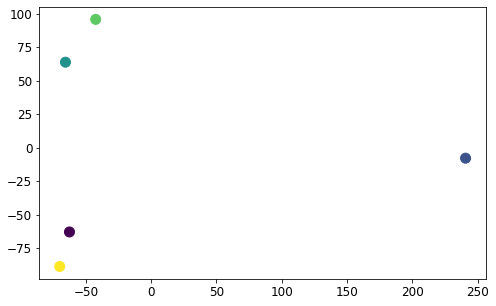

In [23]:
# PCA on cluster means

z_means = PCA(2).fit_transform(cmeans)
plt.figure(figsize=(8, 5))
plt.scatter(z_means[:,0], z_means[:,1], c=[0,1,2,3,4], s=100)
plt.show()

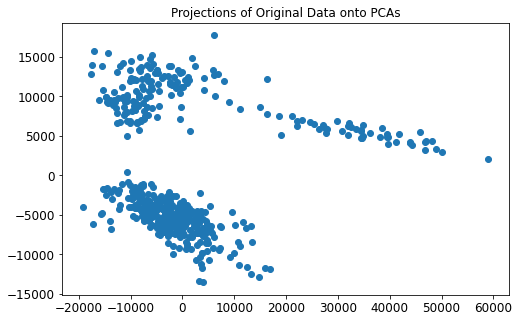

In [24]:
# Transforming original data into PCAs and plotting the results

pca = PCA(50).fit(X)
z = pca.transform(X)
plt.figure(figsize=(8, 5))
plt.scatter(z[:,0], z[:,1])
plt.title('Projections of Original Data onto PCAs')
plt.show()

breaking at iteration 253 with stress 2553223851160.1455


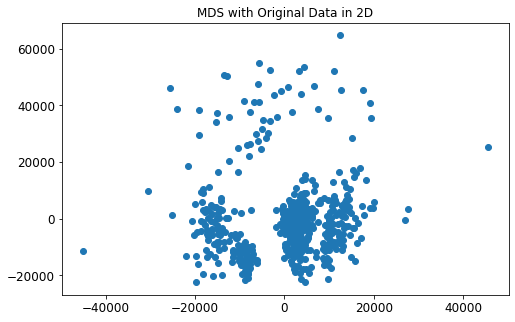

In [25]:
# Plotting MDS with original data

mds = MDS(n_components=2, verbose=1, eps=1e-5)
mds.fit(z[:,0:50])
plt.figure(figsize=(8, 5))
plt.scatter(mds.embedding_[:,0], mds.embedding_[:,1])
plt.title('MDS with Original Data in 2D')
plt.show()

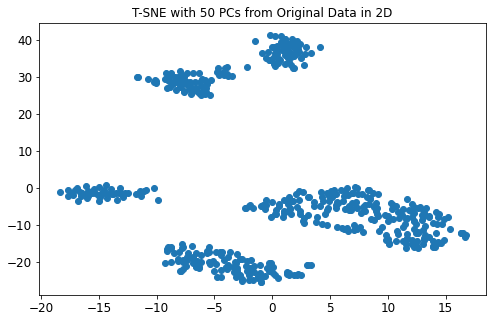

In [26]:
# Plottin T-SNE with original data 

z_tsne = TSNE(n_components=2, perplexity=40).fit_transform(z[:,0:50])
plt.figure(figsize=(8, 5))
plt.scatter(z_tsne[:,0], z_tsne[:,1])
plt.title('T-SNE with 50 PCs from Original Data in 2D')
plt.show()

We can see from the plots that if we use the original data without the logarithmic transformations, the clustering methods do not distinguish the different clusters so well anymore.

# Problem 2: Larger unlabeled subset (Written Report)

Now we will work with the larger, unlabeled subset in p2_unsupervised. This dataset has not been processed, so you should process using the same log transform as in Problem 1.

# Part 1: Visualization

A scientist tells you that cells in the brain are either excitatory neurons, inhibitory neurons, or non-neuronal cells. Cells from each of these three groups serve different functions within the brain. Within each of these three types, there are numerous distinct sub-types that a cell can be, and sub-types of the same larger class can serve similar functions. Your goal is to produce visualizations which show how the scientist's knowledge reflrects in the data.

Provide at least one visualization which clearly shows the existence of the three main brain cell types described by the scientist, and explain how it shows this. Your visualization should support the idea that cells from a different group (for example, excitatory vs inhibitory) can differ greatly.

In [32]:
# Loading full dataset

X = np.load('p2_unsupervised/X.npy')

In [41]:
# X.shape, X_reduced.shape

In [38]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,45758,45759,45760,45761,45762,45763,45764,45765,45766,45767
count,2169.000000,2169.0,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000,...,2169.0,2169.000000,2169.0,2169.0,2169.0,2169.0,2169.0,2169.0,2169.0,2169.0
mean,0.110611,0.0,98.091895,86.897167,0.554270,5.779733,6.894413,0.001044,89.079165,61.248565,...,0.0,0.001185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.810804,0.0,75.426810,73.125116,4.709092,16.266932,18.607467,0.025506,88.282753,66.884891,...,0.0,0.055186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.0,50.489342,41.199776,0.000000,0.000000,0.000000,0.000000,18.603613,26.361708,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.0,91.372918,76.314227,0.000000,0.000000,1.534908,0.000000,76.022418,47.324554,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.0,132.471480,116.904477,0.000000,6.482292,6.857246,0.000000,130.105918,77.552055,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,61.777217,0.0,1183.630346,959.055180,171.095223,360.513827,357.981998,0.878116,959.647646,1141.289961,...,0.0,2.570152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Making logarithmic transformation log2(x+1)

X_log = np.log2(X+1)

In [43]:
pd.DataFrame(X_log).describe()

,0,1,2,3,4,5,6,7,8,9,...,45758,45759,45760,45761,45762,45763,45764,45765,45766,45767
count,2169.000000,2169.0,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000,2169.000000,...,2169.0,2169.000000,2169.0,2169.0,2169.0,2169.0,2169.0,2169.0,2169.0,2169.0
mean,0.036685,0.0,5.841873,5.597379,0.203454,1.229826,1.670285,0.001177,5.237282,5.201388,...,0.0,0.000846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.316316,0.0,2.169343,2.223047,0.696060,1.850324,1.758447,0.028209,2.619062,1.870837,...,0.0,0.039422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.0,5.686202,5.399163,0.000000,0.000000,0.000000,0.000000,4.293048,4.774086,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.0,6.529398,6.272662,0.000000,0.000000,1.341933,0.000000,6.267207,5.594685,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.0,7.060388,6.881475,0.000000,2.903480,2.974024,0.000000,7.034589,6.295577,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5.972169,0.0,10.210221,9.906974,7.427063,8.497907,8.487768,0.909286,9.907864,10.157713,...,0.0,1.835986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that the scaling of the variables made the mean closer to zero and the standard deviation shrunk considerably.

In [44]:
# Transforming processed data into PCAs with 50 PCs

pca = PCA(n_components=50)
z = pca.fit_transform(X_log)

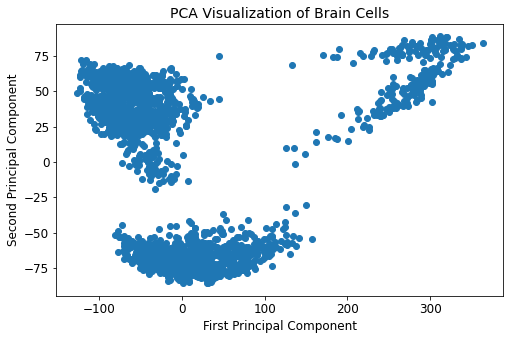

In [45]:
# Plotting the first two components

plt.figure(figsize=(8, 5))
plt.scatter(z[:,0], z[:,1])
plt.title("PCA Visualization of Brain Cells", fontsize=14)
plt.xlabel("First Principal Component", fontsize=12)
plt.ylabel("Second Principal Component", fontsize=12)
#save_fig("PCA_visualization_plot")
plt.show()

In [46]:
pca.explained_variance_ratio_[0:2]

array([0.15494937, 0.04430162])

By using PCA to decompose the data into principle components, which are the sequences of projections of the data that are mutually uncorrelated and ordered in variance, we can demonstrate the presence of the three basic types of brain cells. The first two main components, with the largest variance across all linear combinations of features, are displayed in the plot.We can plainly see the creation of three different cell groups by condensing the dimensions into two-dimensional primary components. Around 15.5 percent of the dataset's variance is explained by the first component, and 4.4 percent by the second. The general result would remain the same even if the data were split into more components, such as 1253 components, which would account for 85% of the variance.


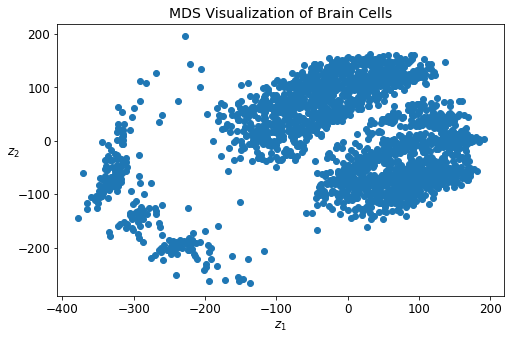

In [51]:
# Visualizing data with MDS on the first 50 PCs

mds = MDS(n_components=2, random_state=42).fit_transform(z[:,0:50])
plt.figure(figsize=(8, 5))
plt.scatter(mds[:,0], mds[:,1])
plt.xlabel("$z_1$", fontsize=12)
plt.ylabel("$z_2$", fontsize=12, rotation=0)
plt.title('MDS Visualization of Brain Cells', fontsize=14)
#save_fig("MDS_visualization_plot")
plt.show()

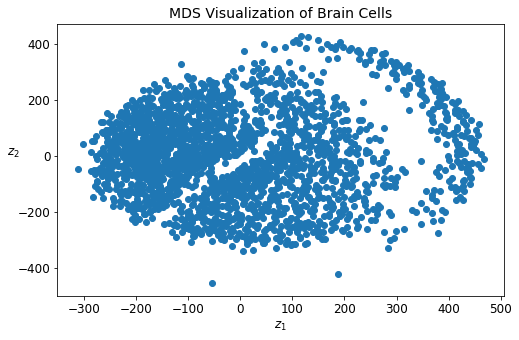

In [53]:
# Visualizong data with MDS on PCs with 85% explained variance

z_85 = PCA(n_components=0.85).fit_transform(X_log)
mds = MDS(n_components=2, random_state=42).fit_transform(z_85)
plt.figure(figsize=(8, 5))
plt.scatter(mds[:,0], mds[:,1])
plt.xlabel("$z_1$", fontsize=12)
plt.ylabel("$z_2$", fontsize=12, rotation=0)
plt.title('MDS Visualization of Brain Cells', fontsize=14)
#save_fig("MDS_visualization_plot_2")
plt.show()

We can also observe about three alternative formations of unique groups of cells if we plot the MDS on PCs that explain 85% of the variance. The distinction between the groups is less evident, though, if we employ fewer components.

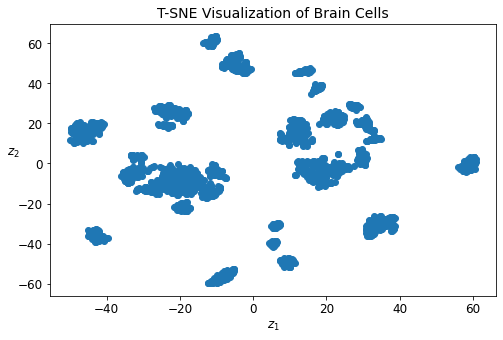

In [54]:
# Visualizing data with TSNE on the first 50 PCs

tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(z[:,0:50])
plt.figure(figsize=(8, 5))
plt.scatter(tsne[:,0], tsne[:,1])
plt.xlabel("$z_1$", fontsize=12)
plt.ylabel("$z_2$", fontsize=12, rotation=0)
plt.title('T-SNE Visualization of Brain Cells', fontsize=14)
#save_fig("TSNE_visualization_plot")
plt.show()

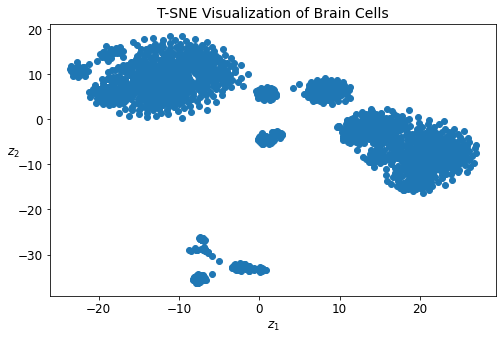

In [55]:
# Visualizong data with TSNE on PCs with 85% explained variance

tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(z_85)
plt.figure(figsize=(8,5))
plt.scatter(tsne[:,0], tsne[:,1])
plt.xlabel("$z_1$", fontsize=12)
plt.ylabel("$z_2$", fontsize=12, rotation=0)
plt.title('T-SNE Visualization of Brain Cells', fontsize=14)
#save_fig('TSNE_visualization_plot_2')
plt.show()

There are more than three distinct clusters in the t-SNE plots above. Using the K-Means approach, where the squared Euclidean distance is selected as the dissimilarity measure to cluster the points by minimizing the average distance between the cluster mean and its points, we may produce cluster labels to demonstrate that these correspond to cell-subtypes. Then, using new colours to represent the various cluster labels, we replot the PCA and t-SNE visualization

Inertia with 4 clusters: 102411510.00626826


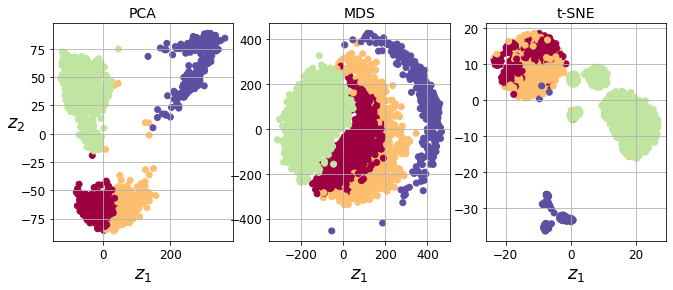

In [56]:
# K-Means Clustering with 4 clusters

z_85 = PCA(n_components=0.85).fit_transform(X_log)
kmeans = KMeans(n_clusters=4).fit(z_85)
kmeans_pred4 = kmeans.fit_predict(z_85)
print("Inertia with 4 clusters:",kmeans.inertia_)

titles = ["PCA", "MDS", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, z in zip((131, 132, 133), titles, (z_85, mds, tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(z[:, 0], z[:, 1], c=kmeans_pred4, cmap=mpl.cm.Spectral)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#save_fig("subgroups_in_clusters")
plt.show()

Inertia with 6 clusters: 99241943.72183427


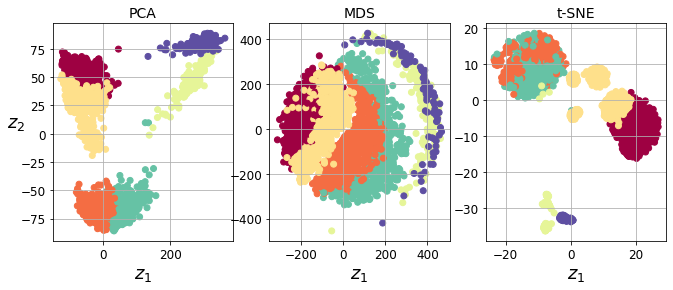

In [57]:
# K-Means Clustering with 4 clusters

kmeans = KMeans(n_clusters=6).fit(z_85)
kmeans_pred4 = kmeans.fit_predict(z_85)
print("Inertia with 6 clusters:",kmeans.inertia_)

titles = ["PCA", "MDS", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, z_85 in zip((131, 132, 133), titles, (z_85, mds, tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(z_85[:, 0], z_85[:, 1], c=kmeans_pred4, cmap=mpl.cm.Spectral)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

#save_fig("subgroups_in_clusters_2")
plt.show()

We can see from the plots that within the three types there are numerous possible sub-types for a cell and that these smaller clusters correspond to cell-subtypes that belong to the three bigger cell groups.

# Part 2: Unsupervised Feature Selection

Now we attempt to find informative genes which can help us differentiate between cells, using only unlabeled data. A genomics researcher would use specialized, domain-specific tools to select these genes. We will instead take a general approach using logistic regression in conjunction with clustering. Briefly speaking, we will use the p2_unsupervised dataset to cluster the data. Treating those cluster labels as ground truth, we will fit a logistic regression model and use its coefficients to select features. Finally, to evaluate the quality of these features, we will fit another logistic regression model on the training set in p2_evaluation, and run it on the test set in the same folder.

1. Using your clustering method(s) of choice, find a suitable clustering for the cells. Support your choice of clustering with appropriate visualizations and/or numerical findings. Be sure to briefly explain how you chose the number of clusters.

The K-Means algorithm, one of the most popular iterative descent clustering techniques, can be used to attempt to group the cells into clusters. This algorithm is designed for situations in which all variables are of the quantitative variety and where the squared Euclidean distance is selected as the dissimilarity metric. By reducing the average distance between the cluster mean and its points, the data are clustered.I will calculate the distance between each instance and its centroid in order to assess the performance of a K-Means model and choose the best one. Inertia, which is the total of the squared distances between each training instance and its nearest centroid, is used to measure this. In order to select the optimal number of clusters to describe the data, I then plot the inertia as a function of clusters.

[816022.5, 335525.65625, 126052.109375, 72572.9609375, 56657.7734375, 42371.9296875, 35418.39453125, 30917.95703125, 26661.546875]


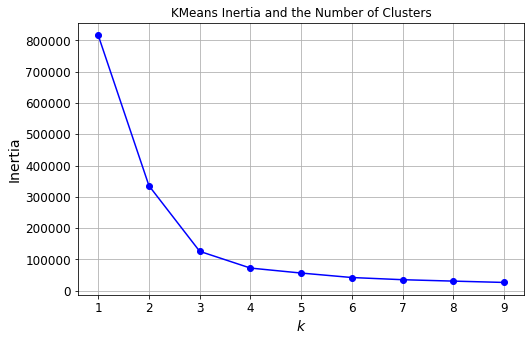

In [58]:
# Running K-means on PCA  data with 50 principal components

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(z)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
print(inertias)
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title("KMeans Inertia and the Number of Clusters")
plt.grid(True)
#save_fig("KMeans_Inertia_and_k_plot")
plt.show()

The plot demonstrates that as we increase k up to 3, the inertia declines quite quickly, but as we continue to increase k, the inertia drops more slowly. The "elbow" points of the curve, where the rate of change in inertia after a drop, is found at k=3. But the inertia also keeps going down when we add more clusters, suggesting that employing additional clusters might lead to a better solution. Then do a silhouette score analysis, which gives the average silhouette coefficient across all cases, to get a deeper look at these clusters. An instance's location within its own cluster and distance from other clusters can be determined by plotting the silhouette score (Shahapure et al, 2020: Ogbuabor and Ugwoke, 2018). It can also be determined if an instance is close to a cluster border or has possibly been placed in the incorrect cluster.

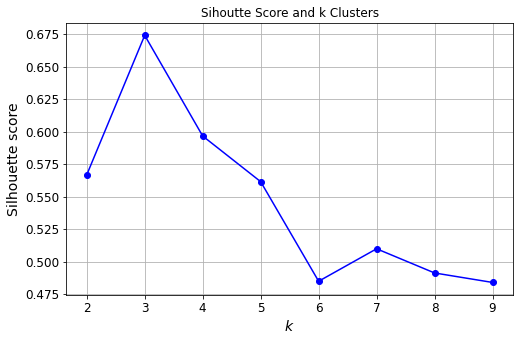

In [59]:
# Silhoutte score of kmeans on PCA  data with 50 principal components

silhouette_scores = [silhouette_score(z, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Sihoutte Score and k Clusters")
plt.grid(True)
plt.show()

One can now observe that modelling the data with three and four clusters yields the best results, but the results seem to be getting better after seven clusters. Plotting each instance's silhouette coefficient while sorting them according to the cluster they belong to and the coefficient's value results in an even more illuminating image. Following that, I plot the Silhoutte Diagram.

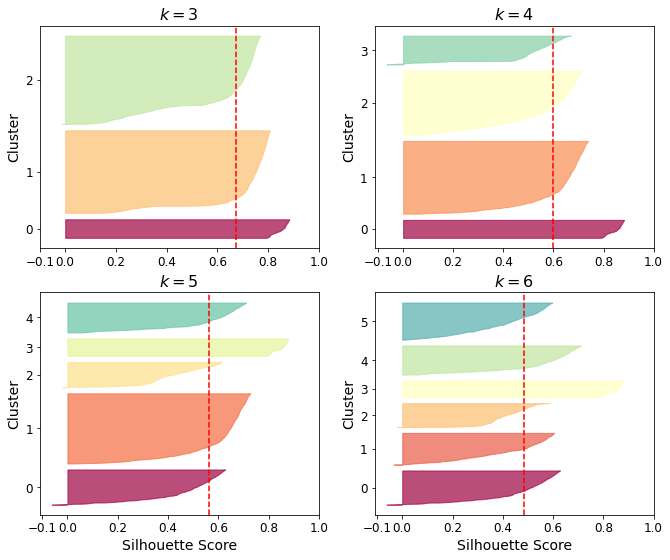

In [60]:
# Plotting Silhoutte Diagram for clusters 3,4,5 and 6

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2,2,k-2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(z, y_pred)

    padding = len(z) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (5, 6):
        plt.ylabel("Cluster")
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Score")

    else:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.ylabel("Cluster")

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

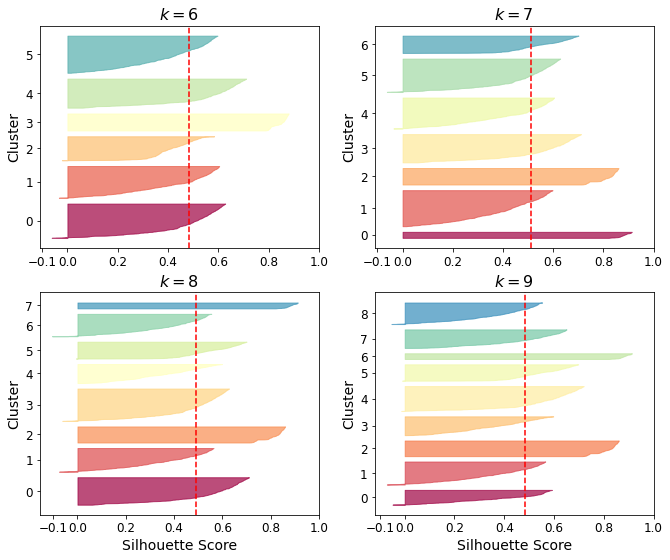

In [61]:
# Plotting Silhoutte Diagram for clusters 6,7,8 and 9

from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (6, 7, 8, 9):
    plt.subplot(2,2,k-5)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(z, y_pred)

    padding = len(z) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (8, 9):
        plt.ylabel("Cluster")
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Score")

    else:
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.ylabel("Cluster")

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

The knife-shaped figures show that, on the first two plots, one cluster appears to collect a disproportionately large number of datapoints relative to the other clusters. This shows that modelling the data with more than five clusters does not provide a sufficient manner of modelling the data, despite the fact that the Silhoutte Score lowers significantly when we increase the number of clusters.

Additionally, it appears that we may try using a different approach to cluster the points in order to discover a better answer.Hierarchical clustering, on the other hand, offers a method that does not necessitate specifying the number of clusters to be searched, whereas the K-means clustering algorithm requires. Instead, a measure of dissimilarity between groups of observations, based on pairwise differences between the observations in the groups, must be specified.Agglomerative hierarchical clustering begins at the base and recursively combines a chosen pair of clusters into a single cluster at each level. As a result, there is one fewer cluster in the grouping at the following higher level. The two groups with the least intergroup dissimilarity are the ones that make up the pair that will be merged. One way to implement this is to use Ward's method which minimizes the total within-cluster variance so that at each step it finds the pair of clusters that lead to a minimum increase in total within-cluster variance after merging.
 
The cophenetic correlation coefficient, which ranges from zero to one, can be used to determine how effectively the approach preserves the original distances and how closely the hierarchical structure created by the connection resembles the data itself.We obtain a cophenetic correlation coefficient value near to 1, which shows that the method maintains the original distances pretty well, using the PCA produced data with 50 principle components.

In [62]:
# Generating matrix for Ward linkage and calculating cophenetic correlation coefficient on PCA data with 50 principal components

Z = linkage(z, 'ward')

c, coph_dists = cophenet(Z, pdist(z))
c

0.8146922983781915

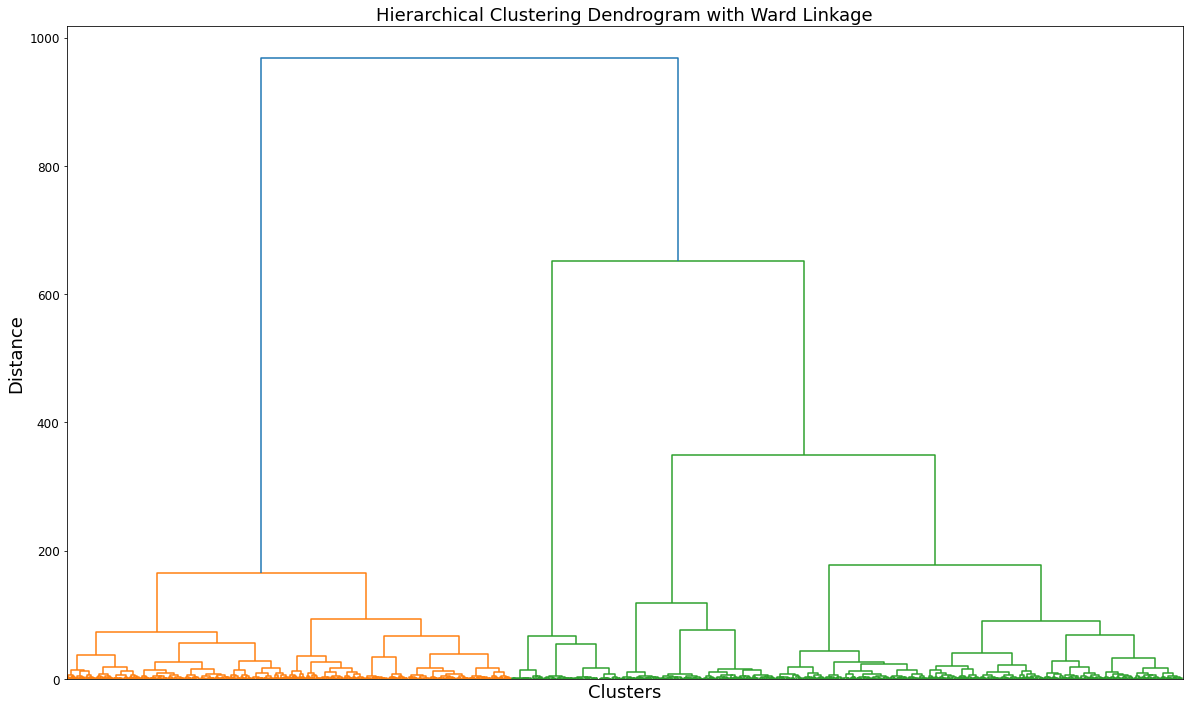

In [63]:
# Plotting full dendrogram with Ward Linkage

plt.figure(figsize=(20, 12))
plt.title('Hierarchical Clustering Dendrogram with Ward Linkage', fontsize=18)
plt.xlabel('Clusters', fontsize=18)
plt.ylabel('Distance', fontsize=18)
dendrogram(Z, show_leaf_counts=False, no_labels=True)
#save_fig("Hierarchical Clustering Dendrogram with Ward Linkage")
plt.show()

The dendrogram suggests that the two neurones, excitatory and inhibitory, form separate groups from non-neural cells, and that many different subtypes can be found within each of these categories. To ensure that the distances between the clusters are still fairly lengthy and the cluster sizes are proportional to one another, we should cut across the branches at an acceptable height. To determine which number of clusters maintains the maximum score while the number of clusters is increased, we can utilize the Silhoutte score and the Ward 
linkage approach.

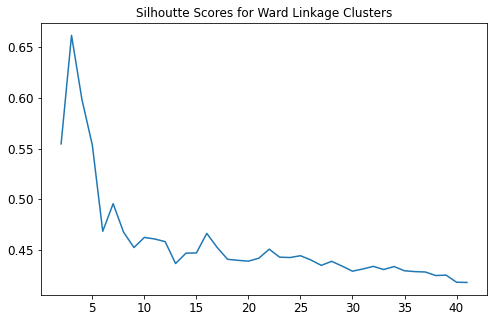

In [64]:
# Plotting Silhoutte Scores for Ward linkage clusters

all_slc = [i for i in range(45)]
for i in range(40):
    slc = AgglomerativeClustering(n_clusters=i+2, linkage="ward")
    slc.fit(z)
    all_slc[i] = slc
plt.figure(figsize=(8, 5))
plt.title('Silhoutte Scores for Ward Linkage Clusters')
plt.plot([i+2 for i in range(40)], [silhouette_score(z, all_slc[i].labels_) for i in range(40)])
plt.show()

In [65]:
# Top silhouette score as a heuristic for number of clusters

best_index = 2 + np.argmax([silhouette_score(z,all_slc[i].labels_) for i in range(2,40)])
# Number of clusters is index + 2 # Ignoring the first two entries because we want more clusters
print("Number of clusters:",best_index+2)

Number of clusters: 4


In [66]:
# Saving labels for training

labels = all_slc[best_index].labels_

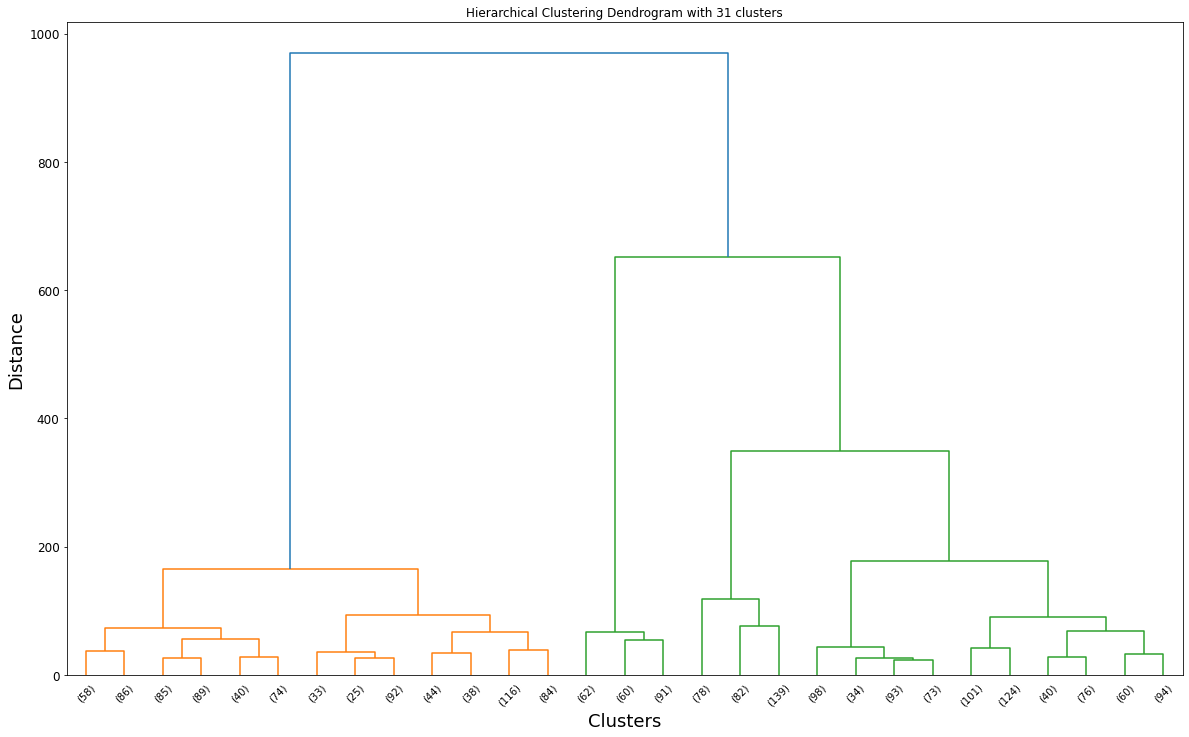

In [67]:
# Plotting truncated dendrogram with 31 clusters

plt.figure(figsize=(20, 12))
plt.title('Hierarchical Clustering Dendrogram with 31 clusters')
plt.xlabel('Clusters', fontsize=18)
plt.ylabel('Distance', fontsize=18)
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=29,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=45.,
    leaf_font_size=10.,
)
#save_fig("Hierarchical_Clustering_Dendrogram_with_31_Clusters")

plt.show()

We can see the deondrogram has two larger groups which form smaller groups insie them. Under each cluster the figure in parantheses indicates the size of the cluster which looks quite balanced.

# Logistic Regression

1. We will now treat your cluster assignments as labels for supervised learning. Fit a logistic regression omdel to the original data (not principal components), with your clustering as target labels. Since the data is high-idmensional, make sure to regularize your model using your choice of , , or elastic net, and separate the data into training and validation or use cross-validation to select your model. Report your choice of regularization parameter and validation performance.

In [68]:
# Standardizing data by removing the mean and scaling to unit variance

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

In [69]:
# Logistic Regression with L1 regularization for feature selection with cross-validation

%memit -r 1

lr = LogisticRegressionCV(penalty="l1", solver="liblinear", Cs=[.1,1,10], cv=3)
%timeit -n 1 -r 1 lr.fit(X_scaled, labels)

peak memory: 1705.67 MiB, increment: 0.29 MiB
3min 32s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [70]:
# Saving model

with open("log_reg_scaled.pkl", "wb") as f:
    pickle.dump(lr, f)

In [71]:
# Accuracy

lr.score(X_scaled ,labels)

1.0

In [72]:
print('Number of features during fit:',len((np.where(lr.coef_ >= 0)[1])),'\nNumber of features after fit:',len(np.where(lr.coef_ > 0)[1]))

Number of features during fit: 182968 
Number of features after fit: 153


The L1 regularized logistic regression or Lasso Regression, is widely used for many classification problems, particularly ones with many features as it is the case now. Regularization is required to avoid over-fitting, when there is only a small number of training examples, or when there are a large number of parameters to be learned. In particular, L1 regularized logistic regression is often used for feature selection as it shrinks the less important feature's to zero, removing some features altogether. 

1. Select the features with the top 100 corresponding coefficient values (since this is a multi-class model you can rank the coefficients using the maximum absolute value over classes, or the sum of absolute values). Take the evaluation training data and use a subset of the genes consisting of the features you selected. Train a logistic regression classifier on this training data, and evaluate its performance on the evaluation test data. Report your score. Compare with two baselines: random features (take a rando selection of 100 genes), and high-variance features (take the 100 genes with highest variance). Compare the variances of the features you selected with the highest variance features by plotting a histogram of the variances of features selected by both methods.

In [73]:
# Top 100 features by taking features with the largest magnitude coefficients

coef_abs = np.abs(lr.coef_)
max_coefs = np.max(coef_abs,axis=0)
features = np.argpartition(max_coefs, -100)[-100:]
features

array([ 6738,  4195, 10282,  2078,  7289, 40045, 25032, 34833, 24018,
       38607, 45083,  3637, 35062,  6370,  5051, 40962, 44086, 45406,
        3278, 10517, 26898,  3550, 38579, 25530, 34904,  6942, 36993,
       24158, 34925, 42920,  6864, 25004,  6750,  8467, 39028, 23672,
        2604,  8579, 24577,  7751, 42214,  1983,  7914,  7033,  7555,
       38611,  4274, 40972, 38864, 34569, 37555,  4663,  2961,  8403,
       41822,  6025, 44773, 39723,  3936, 26116,  2261, 38602, 38324,
        3344, 34591,  6756, 35046, 23587,  3487,  4386, 42716,  3484,
       14053, 39439,  1815, 23512, 43898, 40741,  8196,  5754, 39165,
       35061,  3903,  3747, 32109,  8589, 18073, 36803,  8586, 13242,
       25473, 31577, 15051, 40620,  6754, 40611,  6749,  8404, 39681,
        1729], dtype=int64)

In [74]:
# Loading all evaluation sets

X_train = np.load('p2_evaluation/X_train.npy')
y_train = np.load('p2_evaluation/y_train.npy')

X_test = np.load('p2_evaluation/X_test.npy')
y_test = np.load('p2_evaluation/y_test.npy')

In [75]:
X_train.shape, y_train.shape

((1077, 45768), (1077,))

In [76]:
X_test.shape, y_test.shape

((1108, 45768), (1108,))

In [77]:
# Making logarithmic transformation log2(x+1)

X_train_log = np.log2(X_train+1)
X_test_log = np.log2(X_test+1)

In [78]:
# Standardizing data by removing the mean and scaling to unit variance

X_train_scaled = scaler.fit_transform(X_train_log)
X_test_scaled = scaler.transform(X_test_log)

In [79]:
# Fitting top 100 features on standardized evaluation data with cross-validation

%memit -r 1

lr2 = LogisticRegressionCV(penalty="l2", solver="liblinear", Cs=[.001,.1,1,5,10,50,100], cv=5)
%timeit -n 1 -r 1 lr2.fit(X_train_scaled[:,features] , y_train)

peak memory: 3521.86 MiB, increment: 0.43 MiB
28.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [80]:
# Score for standardized feature selection method

lr2.score(X_test_scaled[:,features], y_test)

0.8474729241877257

By taking the features with the top 100 coefficient values we obtain an accuracy of 84.7 %. Next, we try comparing the two baselines where we select a random selection of 100 genes and 100 genes with the highest variance.

In [81]:
# Selecting genes with high variance as features

variances = np.var(X_log, axis=0)
variance_features = np.argpartition(variances, -100)[-100:]
variance_features

array([ 6648, 38848,  8715,  5526, 34301, 38551, 35059,  4987,  4855,
        5752,  8360, 32140, 40481,  2999,  8254, 39861, 25442, 34528,
       34789,  3043, 38846,  6007,  5838,  5815, 37076,  7527,  6724,
        5741, 41899,  4441, 31616,  4407, 40160, 39451, 24590,  3936,
       40166, 25324, 34516,  8511, 25693,  4433, 41711, 25475, 45653,
       24483, 25332,  7288,  4832,  8586,  3320,  7555,  8589,  3840,
        4356, 34844,  6042, 34572,  2549, 38398, 34527,  6756,  7473,
       25473,  4688,  9356, 34455, 37125, 45169, 40470,   875, 41265,
        6864,  5551, 38280, 38286, 24592, 24577, 40043, 39439, 34897,
       31421, 40741, 34900, 41385, 34904,  5809, 37024,  5849, 41782,
       44094, 25530, 38606, 38467,  7030, 41846, 36986, 38860, 36985,
        7896], dtype=int64)

In [82]:
# Fitting high variance features on standardized evaluation data with cross-validation

%memit -r 1

lr3 = LogisticRegressionCV(penalty="l2", solver="liblinear", Cs=[1,3,5,10], cv=5)
%timeit -n 1 -r 1 lr3.fit(X_train_scaled[:,variance_features], y_train)

peak memory: 2612.51 MiB, increment: 0.77 MiB
16.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [83]:
lr3.score(X_test_scaled[:,variance_features], y_test)

0.9187725631768953

By taking the high variance features we obtain a slightly higher accuracy of 91.9%. We try random feature selection next.

In [84]:
# Selecting genes randomly

random_features = np.random.choice(np.arange(X_log.shape[1]), size=100, replace=False)
random_features

array([38399, 23060, 12760, 36819,  5435, 29585, 40867, 41322, 44189,
       14646, 33680, 23406, 39468, 17626,  5745, 27075, 35223, 25267,
       25710, 23770, 31149, 24502, 39245, 14476, 16627, 14997,  3953,
       14764, 43055, 17348, 19901, 38072, 25579,  4742,  9251, 16884,
       10863, 35950, 42286, 31159,  7182, 38323,   587,  8930, 24649,
       35888, 37165, 27422, 11493,  7398,  2231, 33561,  1885, 18157,
       27893, 12581, 12593,  8495, 44573, 13214,  6109, 43372, 23218,
       33221,  7807, 30862, 25245, 43331, 27056, 28324, 19624,  7705,
       17066,  2823, 40229, 28692, 13573, 39558, 36906, 39456, 35213,
       28716, 14723, 30416, 13470, 14540, 44412, 11163,  3995, 18030,
       37487, 22589, 36847, 35827, 35429,  7204,  6131, 25062, 11346,
       36730])

In [85]:
# Fitting 100 random features on standardized evaluation data with cross-validation

%memit -r 1
lr4 = LogisticRegressionCV(penalty="l2", solver="liblinear", Cs=[1,3,5,10], cv=5)
%timeit -n 1 -r 1  lr4.fit(X_train_scaled[:,random_features], y_train)

peak memory: 2749.71 MiB, increment: 0.03 MiB
13.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [86]:
lr4.score(X_test_scaled[:,random_features], y_test)

0.37454873646209386

By choosing randomly the features we can see that the model performs the worst.

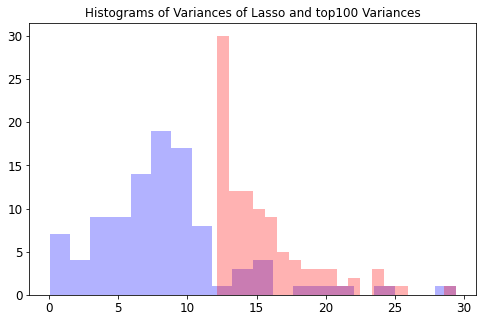

In [87]:
# Plotting Histograms of the variances of features selected by Lasso Regression and the top 100 variances

plt.figure(figsize=(8, 5))
plt.title('Histograms of Variances of Lasso and top100 Variances')
plt.hist(np.var(X_log, axis=0)[features], color="blue", alpha=0.3, bins=20)
plt.hist(np.var(X_log, axis=0)[variance_features], color="red", alpha=0.3, bins=20)
plt.show()

We can see from the histograms that the Lasso Regression chose genes that whose variances were a bit lower and this lead to slightly worse performance than if we would choose to classify with the genes that have the most variance.

# Influence of Hyper-parameters

The hyper-parameter choices used in data analysis techniques can have a large impact on the inferences made. As you have encountered, finding the best choice of parameter such as perplexity in t-SNE or the number of clusters can be an ambiguous problem. We will now investigate the sensitivity of your results to changes in these hyper-parameters, with the goal of understanding how your conclusion may vary depending on these choices.

1. When we created the t-SNE plot in the first problem, we ran T-SNE on the top 50 PC's of the data. But we could have easily chocen a different number of PC's to represent the data. Run T-SNE using 10, 50, 100, 250, and 500 PC's, and plot the resulting visualization for each. What do you observe as you increase the number of PC's used?

1. Pick three hyper-parameters from visualization techniques, clustering techniques and feature selection, and analyze how changing the hyper-parameters affect the conclusions that can be drawn from the data.

In [88]:
# Loading dataset 1 

X = np.load("p1/X.npy")
y = np.load("p1/y.npy")

In [89]:
# Making logarithmic transformation

X_log = np.log2(X+1)

In [90]:
# Tranforming data with PCA

z = PCA(n_components=500).fit_transform(X_log)

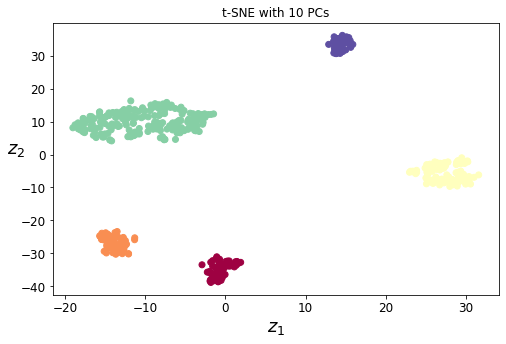

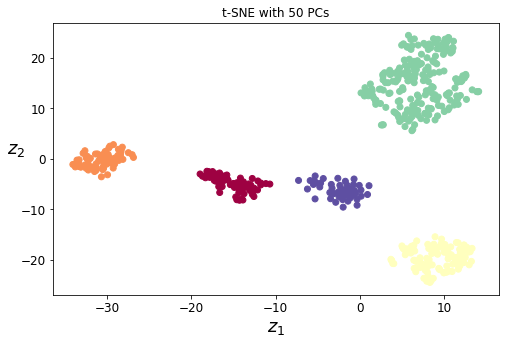

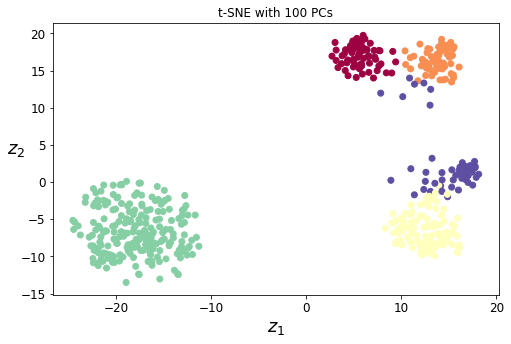

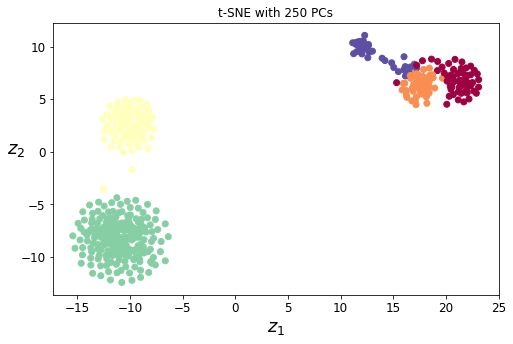

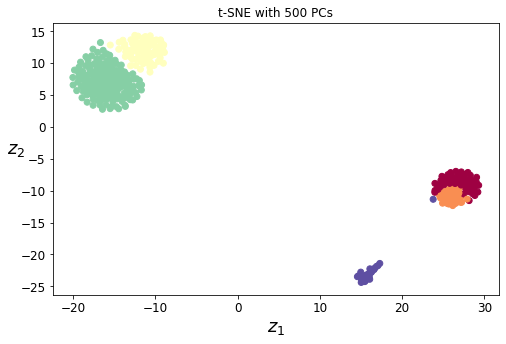

In [91]:
# Plotting t-SNE with different number of principal components

for n_pcs in [10,50,100,250,500]:
    z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:n_pcs])
    plt.figure(figsize=(8,5))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y, cmap=mpl.cm.Spectral)
    plt.title('t-SNE with {} PCs'.format(n_pcs))
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.show()

From the plots we can see than using fewer principal components tend to show the clusters more clearly. Once we increase the number of principal components, the clusters start to merge together and also the range of points inside the cluster increases dramatically (i.e. at 500 PCs).

The change in the number of clusters happens because the PCA is a linear technique and focused on keeping the low-dimensional representations of dissimilar data points far apart by projecting the high-dimensional space into a lower-dimensional subspace. The t-SNE on the other hand reduces dimensionality by non-linear manifolding the data points in such a way that the low-dimensional representations of very similar data points are kept close together by comparing the probabilities that measure the similarity of two data points and minimizing the Kullback-Leibler divergence between those probabilities. Thus, in the beginning adding more principal components increases the information available to the t-SNE algorithm, but at higher dimensions, when the components reach from 250 to 500, the t-SNE technique clusters the data points together just like they were clustered with the PCA.

# Effect of perplexity

T-SNE is a popular method for exploring high-dimensional data created by van der Maaten and Hinton in 2008. In this method, the perplexity parameter is used to balance attention between local and global aspects of the data. It is in a sense, a guess about the number of close neighbors each point has. According to the authors the performance of SNE should be fairly robust to changes in the perplexity, and typical values are between 5 and 50.

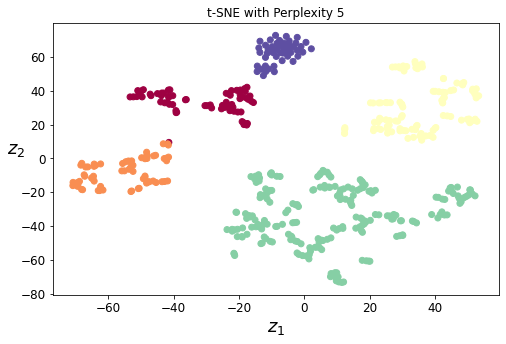

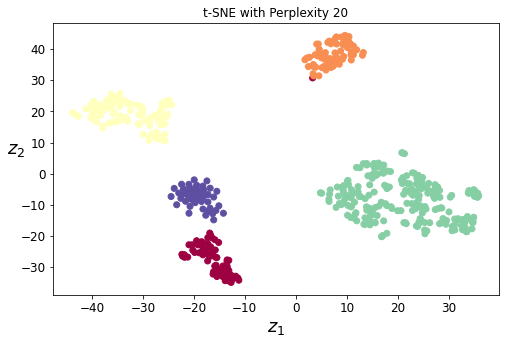

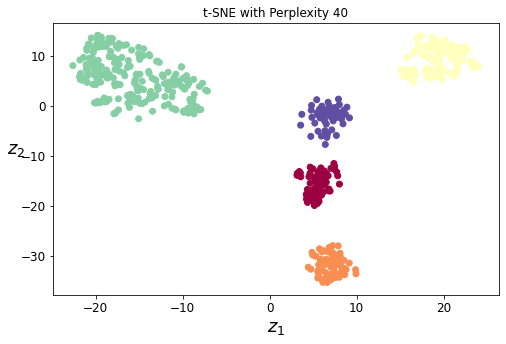

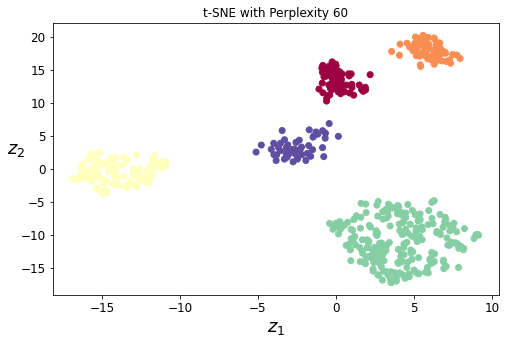

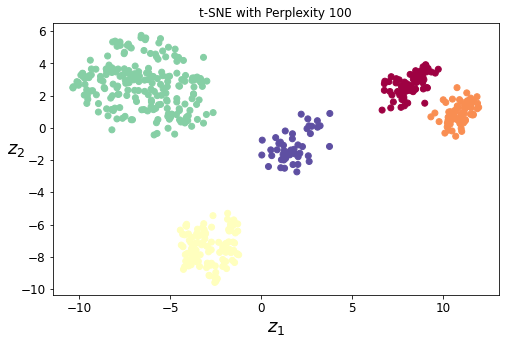

In [92]:
# Plotting t-SNE with 50 PCs and changing perplexity value

for perplexity in [5,20,40,60,100]:
    z_tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(z[:,0:50])
    plt.figure(figsize=(8,5))
    plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y, cmap=mpl.cm.Spectral)
    plt.title('t-SNE with Perplexity {}'.format(perplexity))
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.show()

When increasing the perplexity value of t-SNE with data that has been projected onto 50 principal components, we notice the same five clusters appearing in each plot. However, the more the value is increased the more compressed the datapoints are inside the clusters.

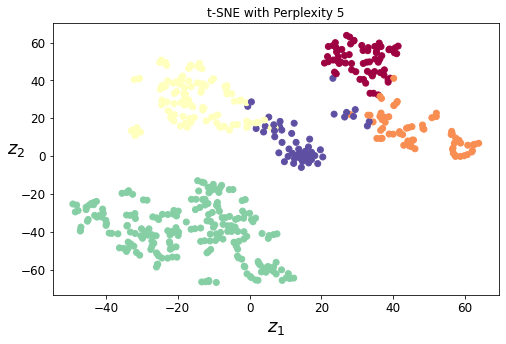

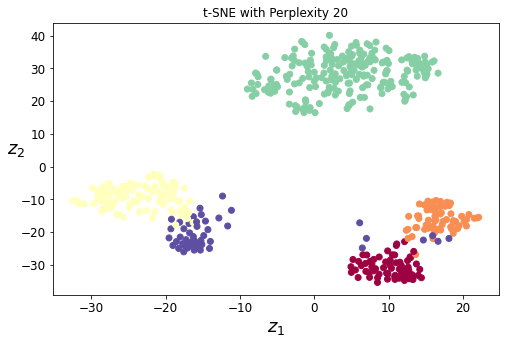

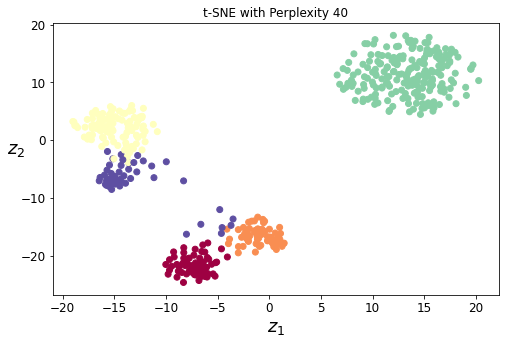

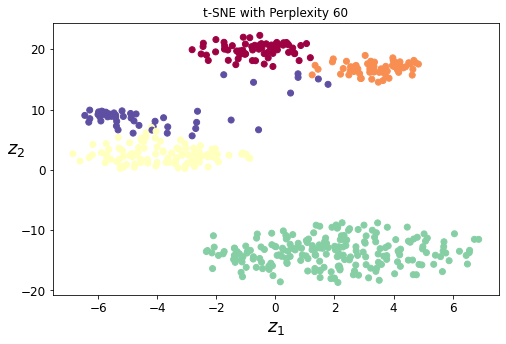

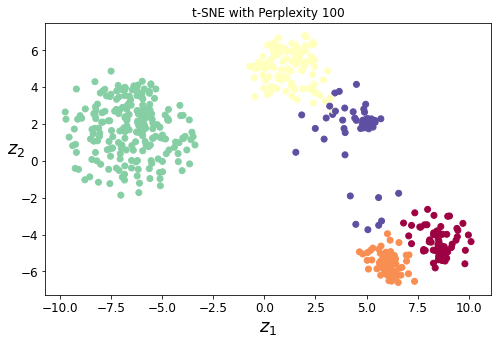

In [93]:
# Plotting t-SNE with 100 PCs and changing perplexity value

for perplexity in [5,20,40,60,100]:
    z_tsne = TSNE(n_components=2,perplexity=perplexity).fit_transform(z[:,0:100])
    plt.figure(figsize=(8,5))
    plt.scatter(z_tsne[:,0],z_tsne[:,1], c=y, cmap=mpl.cm.Spectral)
    plt.title('t-SNE with Perplexity {}'.format(perplexity))
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.show()

We can now notice a difference when using data that is projected into 100 principal components compared to the ones before. The t-SNE algorithm seems to be sensitive to issues associated with high dimensions, as there are more outliers now than before and the clustering of the datapoints is not as informative as it was when using data from lower-dimensions. The clustering does happen especially when the perplexity value is increased to 100 but not as well as before.

# Regularization in Feature Selection

A model needs to be regularized in order to reduce overfitting through constraining the weights of the model. The L2 regularization forces the learning algorithm to fit the data and keep the model weights as small as possible, where as the L1 regularization tends to eliminate the weights of the least important features by setting them to zero. The elastic net is a combination of these two where you control the mix ratio by setting the hyperparameter L1 ratio on each fitting. When you set the ratio to 0 it is equivalent to using the L2 regularization and when set to one equivalent to L1 regularization.

In [94]:
# Evaluating hyper-parameters with the L2 regularization for feature selection with the P2 dataset

X = np.load("p2_unsupervised/X.npy")
X_log = np.log2(X+1)

In [95]:
# Standardizing data by removing the mean and scaling to unit variance

X_scaled = scaler.fit_transform(X_log)

In [96]:
# Logistic Regression with small amount of L2 regularization

%memit -r 1

lr_no_reg = LogisticRegression(penalty="l2", solver="liblinear", C=500)
%timeit -n 1 -r 1 lr_no_reg.fit(X_scaled, labels)

peak memory: 3299.98 MiB, increment: 0.00 MiB
1min 43s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [97]:
# Saving model

with open("log_reg_scaled_no_reg.pkl", "wb") as f:
    pickle.dump(lr_no_reg, f)

In [98]:
# Accuracy

lr_no_reg.score(X_scaled,labels)

1.0

In [101]:
print('Number of features during fit:',len((np.where(lr_no_reg.coef_ >= 0)[1])),'\nNumber of features after fit:',len(np.where(lr_no_reg.coef_ > 0)[1]))

Number of features during fit: 109499 
Number of features after fit: 74355


In [102]:
# Top 100 features by taking features with the largest magnitude coefficients

coef_abs = np.abs(lr_no_reg.coef_)
max_coefs = np.max(coef_abs, axis=0)
features_no_reg = np.argpartition(max_coefs, -100)[-100:]
features_no_reg

array([ 7993, 28589, 36549, 28611, 43865,  3655, 12701, 16646,  3127,
       42552, 22599, 34890, 18002, 44386, 11587,   591, 34908, 20277,
        8196, 42118, 15992, 40656, 39844, 16360, 42920, 23399, 34591,
       38878,  3706, 43898, 20230, 45609, 17099, 29276, 40611, 15447,
       31904, 38962,  4386, 42431,   765,  3487, 29383, 12096, 36993,
       36985, 20020, 18422, 23512, 34170, 35061, 35062, 37265,  9997,
       23650,  9720, 32109,  1983,  5952, 34516, 39984,   723, 18474,
       42214, 18073, 30220, 43289,  8404, 24339,   851, 25488, 18547,
       36803, 35179, 16662, 13523, 13943, 25004, 38538, 45583, 27294,
        1729,  1930, 14053, 19778, 29006, 19752,  5755, 25448, 42570,
        6217, 31237, 17477,  1757,  3903, 35251,  6942,  8614, 13791,
       41299], dtype=int64)

In [103]:
# Fitting top 100 features on standardized evaluation data with cross-validation

%memit -r 1

lr5 = LogisticRegressionCV(penalty="l2", solver="liblinear" , Cs=[.001,.1,1,5,10,50,100], cv=5)
%timeit -n 1 -r 1 lr5.fit(X_train_scaled[:,features_no_reg], y_train)

peak memory: 2375.42 MiB, increment: 0.02 MiB
27.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [104]:
# Score for small amount of L2 regularization as feature selection method

lr5.score(X_test_scaled[:,features_no_reg], y_test)

0.6976534296028881

With a low amount of regularization the score 69.7 % is almost two times worse than what it was with L1 regularization 84.7 %.

In [105]:
# Logistic Regression with large amount of L2 regulatization

%memit -r 1

lr_high_reg = LogisticRegression(penalty="l2", solver="liblinear", C=1e-3)
%timeit -n 1 -r 1 lr_high_reg.fit(X_scaled, labels)

peak memory: 2864.24 MiB, increment: 0.00 MiB
55.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [106]:
# Saving model

with open("log_reg_scaled_high_reg.pkl", "wb") as f:
    pickle.dump(lr_high_reg, f)

In [107]:
# Accuracy

lr_high_reg.score(X_scaled, labels)

1.0

In [108]:
print('Number of features during fit:',len((np.where(lr_high_reg.coef_ >= 0)[1])),'\nNumber of features after fit:',len(np.where(lr_high_reg.coef_ > 0)[1]))


Number of features during fit: 108981 
Number of features after fit: 73837


In [109]:
# Top 100 features by taking features with the largest magnitude coefficients

coef_abs = np.abs(lr_high_reg.coef_)
max_coefs = np.max(coef_abs, axis=0)
features_high_reg = np.argpartition(max_coefs, -100)[-100:]
features_high_reg

array([39062, 42570, 10142,  5622, 25292,  5754,  4441,  6753, 41535,
        2036, 41727,  2569,  8347,  8253,  8210, 38361, 25832, 45583,
       21009, 36985,  8590, 42214, 34890,  5507, 31595, 24422, 42118,
       14973, 38605, 35062,  3655, 31895, 25030,  5632,  4663,  6942,
        8467, 31577, 31862, 30220,  4389,  6626, 40326, 25069, 23883,
       37374, 34224, 35100,  5273,  5527, 26116, 34833, 38604, 38962,
        7897, 40296, 34713, 41865, 36803, 14012,  3487,  4932, 30514,
       36993, 32434, 38538,  1729, 42431, 41464,  3903,  6009,  1983,
       25448, 43898, 40611, 42920, 32109, 42552, 18073, 15013, 36681,
        4386, 23512,  2074,  8196, 45609,   851, 14053, 15051, 24339,
       41299, 39984, 23399, 34908, 23650,  8404, 35061, 34591, 27294,
       25004], dtype=int64)

In [110]:
# Fitting top 100 features on standardized evaluation data with cross-validation

%memit -r 1

lr6 = LogisticRegressionCV(penalty="l2", solver="liblinear", Cs=[.001,.1,1,5,10,50,100], cv=5)
%timeit -n 1 -r 1 lr6.fit(X_train_scaled[:,features_high_reg], y_train)

peak memory: 2867.11 MiB, increment: 0.02 MiB
27.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [111]:
# Score for large amount of L2 regularization as feature selection method

lr6.score(X_test_scaled[:,features_high_reg], y_test)

0.8537906137184116

With a large amount of L1 regularization we get a bit better result of 69.7% compared to the L2 model with less regularization, but which is still lower than with the model with L2 regularization 85.4 %.

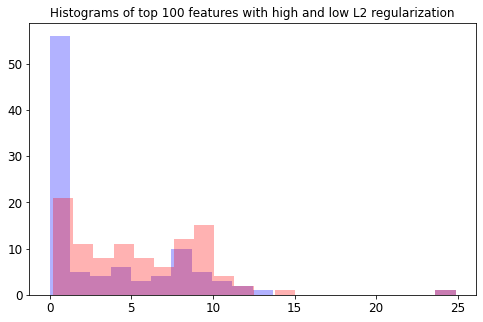

In [112]:
# Plotting Histograms of features selected with low and high regularization

plt.figure(figsize=(8, 5))
plt.title('Histograms of top 100 features with high and low L2 regularization')
plt.hist(np.var(X_log, axis=0)[features_no_reg], color="blue", alpha=0.3, bins=20)
plt.hist(np.var(X_log, axis=0)[features_high_reg], color="red", alpha=0.3, bins=20)
plt.show()

The L2 with high regularization seemed to pick a larger amount of features with higher variance compared to the other. We can have a final look comparing the differences of the top features for all models.

In [113]:
# Comparing differences of the features

print('Difference of features between L1 Regularization and High Variance:',len(np.setdiff1d(features,variance_features)))
print('Difference of features between L1 Regularization and L2 High Regularization:',len(np.setdiff1d(features,features_high_reg)))
print('Difference of features between L1 Regularization and L2 Low Regularization:',len(np.setdiff1d(features,features_no_reg)))
print('Difference of features between L2 High Regularization and L2 Low Regularization:',len(np.setdiff1d(features_high_reg,features_no_reg)))
print('Difference of features between L2 High Regularization and High Variance:',len(np.setdiff1d(features_high_reg,variance_features)))
print('Difference of features between L2 Low Regularization and High Variance:',len(np.setdiff1d(features_no_reg,variance_features)))

Difference of features between L1 Regularization and High Variance: 88
Difference of features between L1 Regularization and L2 High Regularization: 71
Difference of features between L1 Regularization and L2 Low Regularization: 78
Difference of features between L2 High Regularization and L2 Low Regularization: 57
Difference of features between L2 High Regularization and High Variance: 98
Difference of features between L2 Low Regularization and High Variance: 98


From the results we can see that both of the L2 models - high and low regularization - had the most in common when choosing the features, while both of them had the least in common with the 'picking the top 100 features with the maximum variance' criterion.

The results also show that regularization was indeed needed in order to achieve good results. The L1 method had an edge towards the L2 in the accuracy on the validation test set, although overall, picking the genes with the highest variances proved to be the best method for accuracy.

# Criterion for Hierarchical Clustering

The K-Means Clustering criterion has been covered already with the inspection of inertia and Silhoutte Score, however the hierarchical clustering method also has some hyper-parameters than can be tuned related to the linkage being used.

In the hierarchical clustering methods, the complete and the Ward linkage are both based on the pairwise dissimilarities among the observations of groups of observations. Specifying the measure of dissimilarity between the groups defines what the method of linkage is being used.

While the complete linkage takes the intergroup dissimilarity to be that of the furthest (most dissimilar) pair, the Ward’s method incrementally assigns a point to a cluster based on the minimum increase of error sum-of-squares between a pair of points. Starting at the bottom, both methods recursively merge a selected pair of clusters into a single cluster at each level going upwards. This produces a grouping at the next higher level with one less cluster. The pair chosen for merging consists then of the two groups with the smallest intergroup dissimilarity. The dendrogram below shows the complete linkage from the part two unsupervised data set.

In [114]:
# Loading and transforming processed data into PCAs with 50 PCs

pca = PCA(n_components=50)
z = pca.fit_transform(X_log)

The cophenetic correlation coefficient value for complete linkage: 0.8394330322853103


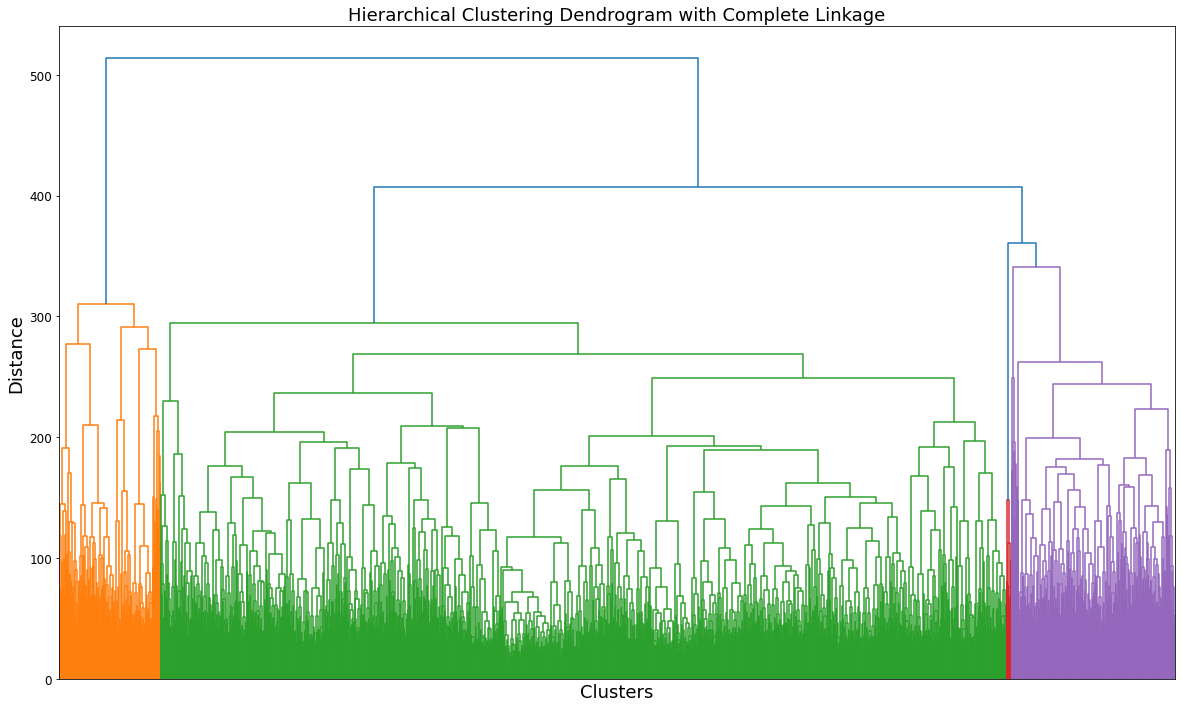

In [115]:
# Plotting dendrogram with complete linkage on the p2 dataset

Z = linkage(z, 'complete')
c, coph_dists = cophenet(Z, pdist(z))
print('The cophenetic correlation coefficient value for complete linkage:',c)

plt.figure(figsize=(20, 12))
plt.title('Hierarchical Clustering Dendrogram with Complete Linkage', fontsize=18)
plt.xlabel('Clusters', fontsize=18)
plt.ylabel('Distance', fontsize=18)
dendrogram(Z, show_leaf_counts=False, no_labels=True)
#save_fig("Hierarchical_Clustering_Dendrogram_with_Complete_Linkage")
plt.show()

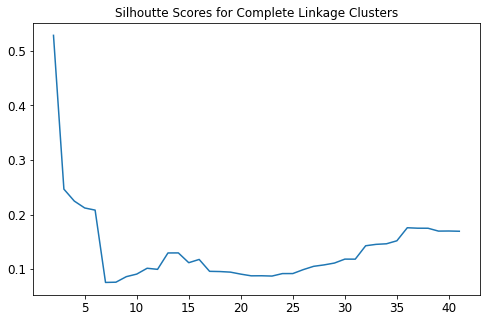

In [116]:
# Plotting Silhoutte Scores for complete linkage clusters

all_slc = [i for i in range(45)]
for i in range(40):
    slc = AgglomerativeClustering(n_clusters=i+2, linkage="complete")
    slc.fit(z)
    all_slc[i] = slc
plt.figure(figsize=(8, 5))
plt.title('Silhoutte Scores for Complete Linkage Clusters')
plt.plot([i+2 for i in range(40)], [silhouette_score(z,all_slc[i].labels_) for i in range(40)])
plt.show()

We can see from the dendrogram that the complete linkage tends to produce many compact clusters with small diameters. However, it can also produce clusters where some members in the cluster are actually much closer to members of other clusters than what they are towards their members of their own cluster. Whereas the Ward’s method, tries to minimize the increase in total within-cluster variance after merging. his increase is a weighted squared distance between cluster centers which is similar to the K-means clustering algorithm.

The cophenic correlation coefficient is lower compared to the one produced by the Ward's method which indicates that the latter method is a better way of clustering the data. This can be also confirmer when plotting the Silhoutte Scores where we can see that it is difficult to pick the right amount of clusters as the graph has a quadratic shape where the value of the score increases as we increase the number of clusters.